<a href="https://colab.research.google.com/github/dlvh/biods271/blob/main/BIODS271_Homework_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2: Vision-Language Foundation Models
Vision-language models (VLMs) jointly learn relationships between images and text. In this assignment, we will explore how VLMs can be used to perform a variety of reasoning tasks on medical images.

❗Make sure to click File > Save a copy in Drive before you get started on this assignment. If you edit this notebook directly, your changes will not be saved.

❗Before you get started, click Runtime > Change Runtime Type and select "T4 GPU". Then, click "Connect" in the upper right hand corner of this notebook.

### Install Python Packages

In [3]:
# Run this cell to install necessary Python packages
!pip install open_clip_torch

  Using cached open_clip_torch-2.32.0-py3-none-any.whl.metadata (31 kB)
  Using cached ftfy-6.3.1-py3-none-any.whl.metadata (7.3 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (

### Load Python Packages

In [4]:
# Python packages that may be useful
import open_clip
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Part 1 [Coding Questions]: Exploring General-Domain Vision-Language Models

### Load OpenCLIP VLM (2 points)

The [OpenCLIP](https://github.com/mlfoundations/open_clip) codebase provides access to a range of pretrained VLMs. Load the pretrained OpenCLIP ViT-B/16 model (id = laion2B-s34B-b88K) and compute the number of model parameters, the context length (i.e. the number of input tokens for the text encoder), and the vocabulary size of the text encoder. This VLM uses a Vision Transformer backbone for the image encoder and was pretrained on the 2 billion image-text pairs included in the LAION-2B dataset.

**Expected Outputs:**
- Number of trained parameters in an OpenCLIP ViT-B/16 model (Hint: this should be in the hundreds of millions!)
- Context length for the text encoder
- Vocabulary size for the text encoder

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load Model
model, _, preprocess = open_clip.create_model_and_transforms(
    "ViT-B-16",
    pretrained="laion2B-s34B-b88K"
)
model.to(device)
model.eval()

# number of trained parameters
num_params = sum(p.numel() for p in model.parameters())
print(f"Number of trained parameters: {num_params:,}")

# context length of the text encoder
context_length = model.positional_embedding.shape[0]
print(f"Context length (number of input tokens): {context_length}")

# vocabulary size of the text encoder
vocab_size = model.token_embedding.num_embeddings
print(f"Vocabulary size: {vocab_size}")

Number of trained parameters: 149,620,737
Context length (number of input tokens): 77
Vocabulary size: 49408


### Exploring CIFAR-100 (2 points)
For the first part of this assignment, we will be working with the [CIFAR-100](https://paperswithcode.com/dataset/cifar-100) dataset, which includes objects from 100 classes.

We'll begin by performing an exploratory analysis. Visualize any ten images from CIFAR-100.

**Expected Output:**
- Visualization of ten CIFAR-100 images

In [42]:
# Load Dataset
cifar_100 = torchvision.datasets.CIFAR100(root='.', train=False, download=True)
class_names = cifar_100.classes

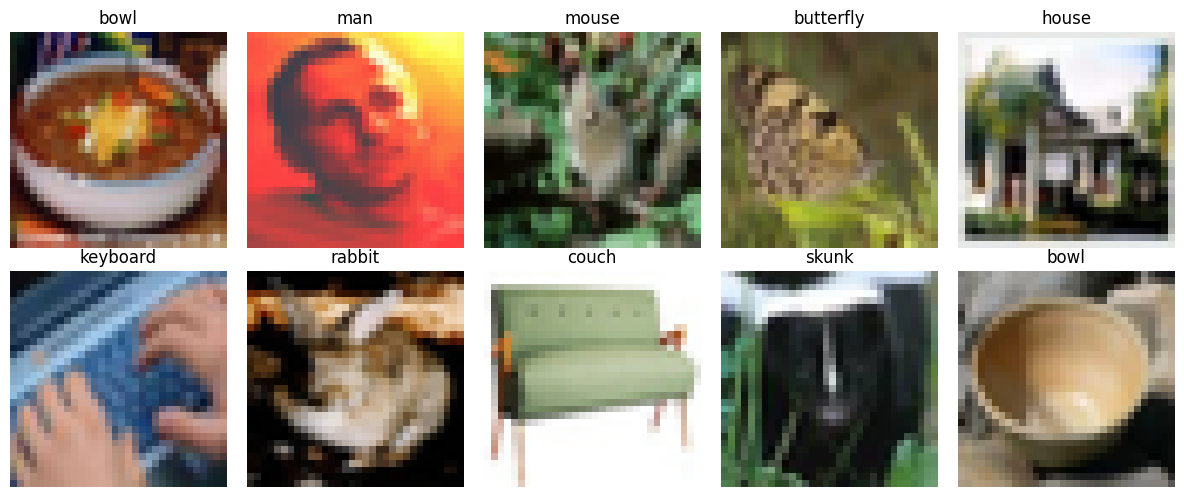

In [43]:
# Your code here
# 10 random images
np.random.seed(42)
indices = np.random.choice(len(cifar_100), size=10, replace=False)
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for ax, idx in zip(axes.flatten(), indices):
    img, label = cifar_100[idx]
    ax.imshow(img)
    ax.set_title(class_names[label])
    ax.axis('off')
plt.tight_layout()
plt.show()

### Perform Zero-Shot Classification (10 points)

Let's evaluate the OpenCLIP ViT-B/16 model by performing zero-shot classification on CIFAR-100.

Use the OpenCLIP ViT-B/16 to encode each image and each label in CIFAR-100. For this task, please directly encode the provided CIFAR-100 class names as text and **do not** perform any prompt tuning or modifications to the label name.

Hint: Is your code too slow? Make sure you're using the GPU!

**Expected Outputs**
- Zero-shot classification accuracy of the OpenCLIP ViT-B/16 model on CIFAR-100. Hint: Classification accuracy should be > 0.6.

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Set up dataloader for CIFAR100
cifar_100 = torchvision.datasets.CIFAR100(root='.', train=False, download=True, transform=preprocess) #Don't forget to fill in the transform!
data_loader = DataLoader(cifar_100, batch_size=64, shuffle=False, drop_last=False)

# Your code here

# CLIP needs text encoding
text_tokens = open_clip.tokenize(class_names).to(device)
with torch.no_grad():
    text_embeddings = model.encode_text(text_tokens)
    text_embeddings = text_embeddings / text_embeddings.norm(dim=-1, keepdim=True)

# Zero-shot Evaluation
correct = 0
total = 0

with torch.no_grad():
    for images, labels in data_loader:
        images = images.to(device)
        labels = labels.to(device)
        image_embeddings = model.encode_image(images)
        image_embeddings = image_embeddings / image_embeddings.norm(dim=-1, keepdim=True)

        logits = image_embeddings @ text_embeddings.T
        preds = logits.argmax(dim=-1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
print(f"Zero-shot classification accuracy: {accuracy:.4f}")

Zero-shot classification accuracy: 0.6695


### Prompt Engineering for VLMs (6 points)

VLMs are sensitive to the input prompts. In the previous step, we directly encoded the labels as text (i.e. "apple" or "cloud"). However, using more descriptive prompts that encode labels as phrases or sentences (e.g. "the apple") can help improve model performance. Can you improve zero-shot classification performance by customizing prompts?

Hint: Is it possible to ensemble a set of multiple prompts for a given class label? See the lecture slides from 04/23 for more information on prompt ensembles.

**Expected Output**
- Zero-shot classification accuracy of the OpenCLIP ViT-B/16 model on CIFAR-100 using your custom prompts. Make sure that your prompts contribute to performance improvements when compared to the results from the previous cell.

Note that this is an open-ended question, and there are many possible solutions.



In [17]:
from tqdm import tqdm

In [18]:
# Your code here

# Prompt Templates
templates = [
    "a photo of a {}.",
    "an image of the {}.",
    "This is a picture of a {}."
]

# Ensemble prompts for each class
prompts = [template.format(c) for c in class_names for template in templates]
text_tokens = open_clip.tokenize(prompts).to(device)

# Encode and ensemble text embeddings
with torch.no_grad():
    text_embs = model.encode_text(text_tokens)  # (100 * 3, dim)
    text_embs /= text_embs.norm(dim=-1, keepdim=True)
    # Reshape to (100, 3, dim), average, then renormalize
    text_embs = text_embs.view(len(class_names), len(templates), -1).mean(dim=1)
    text_embs /= text_embs.norm(dim=-1, keepdim=True)

# Zero-shot evaluation with prompt ensemble
correct = 0
total = 0

with torch.no_grad():
    for images, labels in tqdm(data_loader, desc="Zero-shot Eval (Ensembled Prompts)", unit="batch"):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        img_embs = model.encode_image(images)
        img_embs /= img_embs.norm(dim=-1, keepdim=True)

        logits = img_embs @ text_embs.T
        preds = logits.argmax(dim=-1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
print()
print(f"Zero-shot accuracy with prompt ensemble: {accuracy:.4f}")

Zero-shot Eval (Ensembled Prompts): 100%|██████████| 157/157 [01:57<00:00,  1.34batch/s]

Zero-shot accuracy with prompt ensemble: 0.7690


## Part 2 [Coding Questions]: Exploring Medical Vision-Language Models

Let's now try a medical image dataset. We will use PatchCamelyon (PCam), a dataset consisting of color images extracted from histopathologic scans of lymph node sections. Each image is annotated with a binary label indicating presence of metastatic tissue (label of 1 = lymph node with metastasis; label of 0 = normal lymph node)

In [19]:
# Run the following cell to download PCam

!gdown 1qV65ZqZvWzuIVthK8eVDhIwrbnsJdbg_
!gdown 17BHrSrwWKjYsOgTMmoqrIjDy6Fa2o_gP

# NOTE: The previous two lines of code may occasionally throw an error if too
# many people have attempted to download the file within a short time-frame. If
# you see this error, download the files manually from Google Drive and upload
# to your Colab disk. Then, run the rest of this cell to format the files.
# (File 1) https://drive.google.com/uc?id=1qV65ZqZvWzuIVthK8eVDhIwrbnsJdbg_
# (File 2) https://drive.google.com/uc?id=17BHrSrwWKjYsOgTMmoqrIjDy6Fa2o_gP

!gunzip camelyonpatch_level_2_split_test_x.h5.gz
!gunzip camelyonpatch_level_2_split_test_y.h5.gz

!mkdir pcam
!mv camelyonpatch_level_2_split_test_x.h5 pcam
!mv camelyonpatch_level_2_split_test_y.h5 pcam

Downloading...
From (original): https://drive.google.com/uc?id=1qV65ZqZvWzuIVthK8eVDhIwrbnsJdbg_
From (redirected): https://drive.google.com/uc?id=1qV65ZqZvWzuIVthK8eVDhIwrbnsJdbg_&confirm=t&uuid=37fedec5-200f-48ba-9081-8978bb2a0f76
To: /content/camelyonpatch_level_2_split_test_x.h5.gz
100% 801M/801M [00:16<00:00, 47.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=17BHrSrwWKjYsOgTMmoqrIjDy6Fa2o_gP
To: /content/camelyonpatch_level_2_split_test_y.h5.gz
100% 3.04k/3.04k [00:00<00:00, 16.5MB/s]


### Exploring PCam (2 points)
We'll begin by performing an exploratory analysis. Visualize any ten images from PCam and describe any visual variabilities that you observe between the two classes.

**Expected Output:**
- Visualization of ten PCam images
- Description of visual differences between images from the two classes.

In [20]:
# Load dataset
pcam = torchvision.datasets.PCAM(root='.', split='test', download=False)

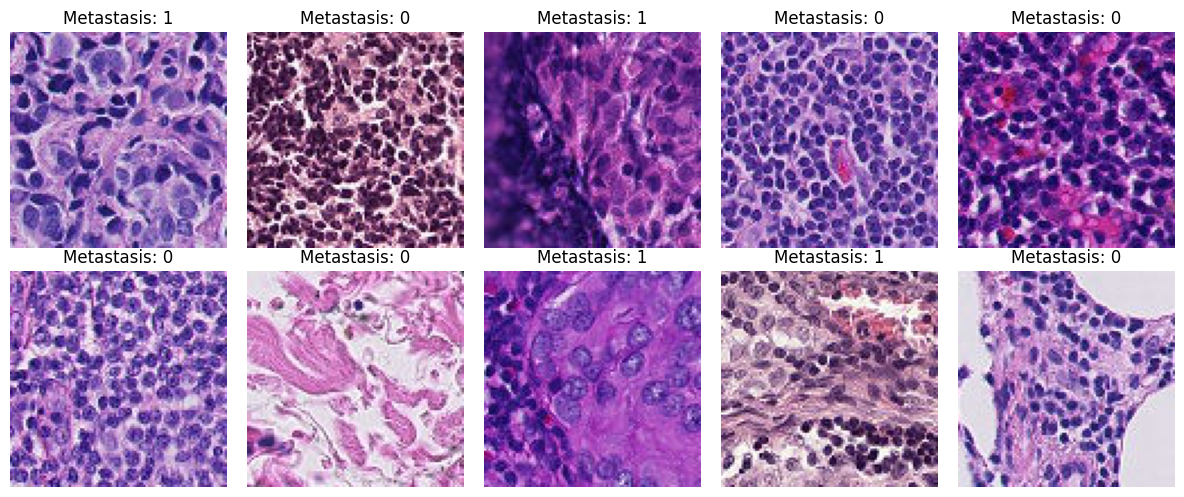

In [24]:
# Your code here
# random 10 images
np.random.seed(42)
indices = np.random.choice(len(pcam), size=10, replace=False)

# Plot and visualization
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for ax, idx in zip(axes.flatten(), indices):
    img, label = pcam[idx]
    ax.imshow(img)
    ax.set_title(f"Metastasis: {label}")
    ax.axis('off')

plt.tight_layout()
plt.show()

**Description of Visual Differences Between Class=0 and Class=1**:

*Disclaimer*: I do not have much biomedical background training so I cannot interpret pathology WSI.

From the visualization above, some of visual differences I picked up are:
- The non-metastasis class images tend to be clearer (more uniform coloring) and the cells are more regular in shape.
- The metastasis class images tend to have multiple cell clusters, with some tainted in a color which tends to be darker.


### Perform Zero-Shot Classification with General-Domain VLM (4 points)

Let's evaluate the OpenCLIP ViT-B/16 model by performing zero-shot binary classification on PCam.

Use the OpenCLIP ViT-B/16 to encode each image and each label in PCam. Feel free to experiment with prompts of your choice.

**Expected Outputs**
- Zero-shot classification accuracy of the OpenCLIP ViT-B/16 model on Pcam

In [27]:
# Set up dataloader for PCam
pcam = torchvision.datasets.PCAM(root='.', split='test', download=False, transform=preprocess) #Don't forget to fill in the transform!
data_loader = DataLoader(pcam, batch_size=64, shuffle=False, drop_last=False)

# Your code here

# Define class prompts similar to Part 1 Prompt Engineering
binary_classes = ["normal tissue", "metastatic tissue"]
templates = [
    "a histopathology image of {}.",
    "an image of {}.",
    "this is a photo of {}."
]

# Ensembling
prompts = [tmpl.format(cls) for cls in binary_classes for tmpl in templates]
text_tokens = open_clip.tokenize(prompts).to(device)

# Encode and Aggregate Text Embedding
with torch.no_grad():
    text_embs = model.encode_text(text_tokens)
    text_embs /= text_embs.norm(dim=-1, keepdim=True)
    # Reshape to (2 classes, 3 templates, dim) and average
    text_embs = text_embs.view(len(binary_classes), len(templates), -1).mean(dim=1)
    text_embs /= text_embs.norm(dim=-1, keepdim=True)

# Zero-shot evaluation on PCam
correct = 0
total = 0

with torch.no_grad():
    for images, labels in tqdm(data_loader, desc="PCam Zero-Shot Eval", unit="batch"):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        img_embs = model.encode_image(images)
        img_embs /= img_embs.norm(dim=-1, keepdim=True)

        logits = img_embs @ text_embs.T
        preds = logits.argmax(dim=-1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
print()
print(f"Zero-shot classification accuracy on PCam: {accuracy:.4f}")

PCam Zero-Shot Eval: 100%|██████████| 512/512 [07:26<00:00,  1.15batch/s]


Zero-shot classification accuracy on PCam: 0.5192


### Perform Zero-Shot Classification with a Biomedical VLM (6 points)

Next, let's explore [BiomedCLIP](https://arxiv.org/abs/2303.00915), a medical VLM pretrained on a large collection of images and text from PubMed. Again, feel free to experiment with prompts of your choice.

**Expected Outputs**:

- Zero-shot classification accuracy of BiomedCLIP on PCam

In [29]:
from open_clip import create_model_from_pretrained, get_tokenizer

# Load BiomedCLIP Weights
model, preprocess = create_model_from_pretrained('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')
tokenizer = get_tokenizer('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')
# device handling
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device).eval()

# Your code here

# Prompt ensemble - experiments
classes = ["normal tissue", "metastatic tissue"]
templates = [
    "a histopathology image of {}.",
    "this histopathology image shows {}."
]
prompts = [t.format(c) for c in classes for t in templates]
text_tokens = tokenizer(prompts).to(device)

# Encode text embeddings
with torch.no_grad():
    text_embs = model.encode_text(text_tokens)
    text_embs /= text_embs.norm(dim=-1, keepdim=True)
    # Average over templates per class
    text_embs = text_embs.view(len(classes), len(templates), -1).mean(dim=1)
    text_embs /= text_embs.norm(dim=-1, keepdim=True)

# Zero-shot evaluation
correct, total = 0, 0
with torch.no_grad():
    for images, labels in tqdm(data_loader, desc="BiomedCLIP PCam Zero-Shot", unit="batch"):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        img_embs = model.encode_image(images)
        img_embs /= img_embs.norm(dim=-1, keepdim=True)
        logits = img_embs @ text_embs.T
        preds = logits.argmax(dim=-1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
print()
print(f"Zero-shot classification accuracy on PCam with BiomedCLIP: {accuracy:.4f}")

BiomedCLIP PCam Zero-Shot: 100%|██████████| 512/512 [07:42<00:00,  1.11batch/s]

Zero-shot classification accuracy on PCam with BiomedCLIP: 0.6845


## Part 3 [Open-Ended Exploration] - Evaluating FMs

### Evaluations (10 points)
Now that we have explored applications of the OpenCLIP ViT-B/16 and the BiomedCLIP VLMs on Pcam, let's perform an open-ended exploration in order to analyze the learned embedding spaces of various FMs. For this task, you will (1) generate image embeddings for each sample in the PCAM test set, (2) cluster the image-level embeddings, and (3) generate cluster visualizations. Details are provided below:
1. *Generate image embeddings*: You will generate embeddings for each image in the PCAM test set.
2. *Cluster image embeddings*: You will use a clustering algorithm of your choice (such as K-means) in order to cluster the embeddings. Hint: If this stage is too time-consuming, it might help to reduce the dimensionality of image embeddings via algorithms like PCA or UMAP.
3. *Visualize clusters*: Generate plots that visualize the clusters. There are many possible options for visualizing clusters; feel free to choose any reasonable approach. Use the ground-truth labels associated with each sample to color each point in your plot.

For full credit on this section, you must evaluate **at least 3** models. At least one of these models must be distinct from the OpenCLIP ViT-B/16 and BiomedCLIP VLMs explored earlier in this notebook. Some examples of models you may evaluate include PLIP (discussed in the 04/07 lecture), other OpenCLIP variants, and CONCH. You may also experiment with vision-only FMs, such as UNI.

In [32]:
from open_clip import create_model_from_pretrained, get_tokenizer
import umap
from sklearn.cluster import KMeans

In [34]:
# PLIP Loading
from transformers import CLIPModel, CLIPProcessor

In [37]:
#Your code here

# LOADING MODELS

# device handling
device = "cuda" if torch.cuda.is_available() else "cpu"

# (1) OpenCLIP ViT-B/16
model1, _, preprocess1 = open_clip.create_model_and_transforms(
    "ViT-B-16", pretrained="laion2B-s34B-b88K"
)
model1.to(device).eval()

# (2) BiomedCLIP
model2, preprocess2 = create_model_from_pretrained(
    "hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224"
)
model2.to(device).eval()

# (3) PLIP ViT-B/16
# LOAD PLIP MODEL
model3 = CLIPModel.from_pretrained("vinid/plip").to(device).eval()
processor3 = CLIPProcessor.from_pretrained("vinid/plip")

In [39]:
# Custom collate_fn to handle PIL Images
def collate_fn(batch):
    images, labels = zip(*batch)
    return list(images), torch.tensor(labels, dtype=torch.long)

# Raw PCam loader (no transform)
raw_pcam = torchvision.datasets.PCAM(
    root='.', split='test', download=False, transform=None
)
loader = DataLoader(
    raw_pcam,
    batch_size=128,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    collate_fn=collate_fn
)

# Generate embeddings
embs1, embs2, embs3, labels = [], [], [], []

with torch.no_grad():
    for imgs, labs in tqdm(loader):
        labels.append(labs.numpy())

        # OpenCLIP embeddings
        batch1 = torch.stack([preprocess1(img) for img in imgs]).to(device)
        embs1.append(model1.encode_image(batch1).cpu().numpy())

        # BiomedCLIP embeddings
        batch2 = torch.stack([preprocess2(img) for img in imgs]).to(device)
        embs2.append(model2.encode_image(batch2).cpu().numpy())

        # PLIP embeddings
        pixel_vals = processor3(
            images=imgs, return_tensors="pt"
        ).pixel_values.to(device)
        embs3.append(model3.get_image_features(pixel_vals).cpu().numpy())


100%|██████████| 256/256 [17:09<00:00,  4.02s/it]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


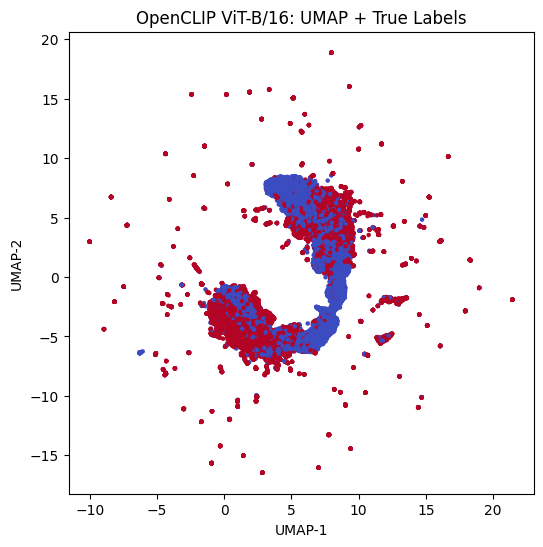

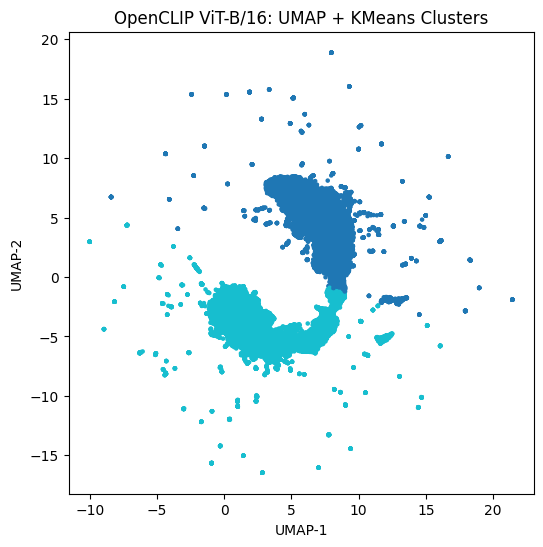

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


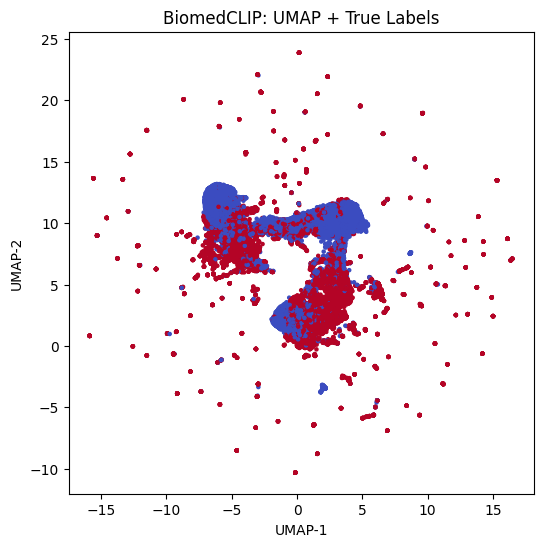

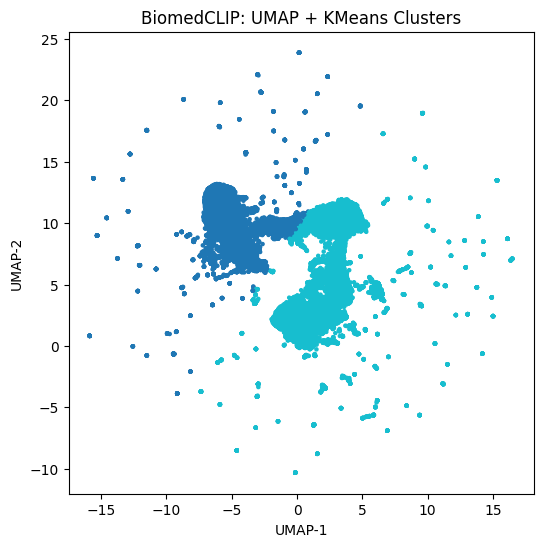

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


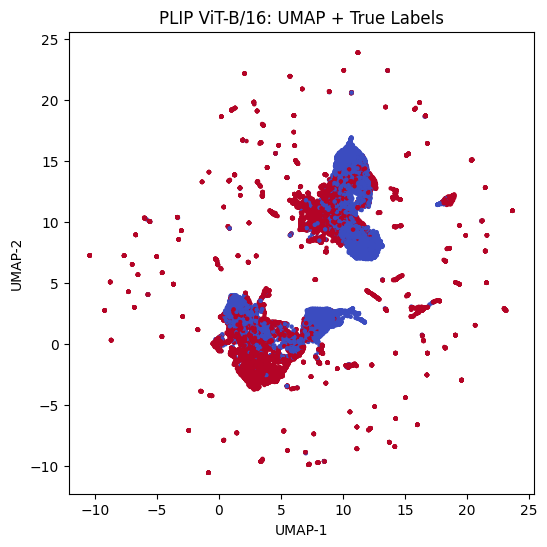

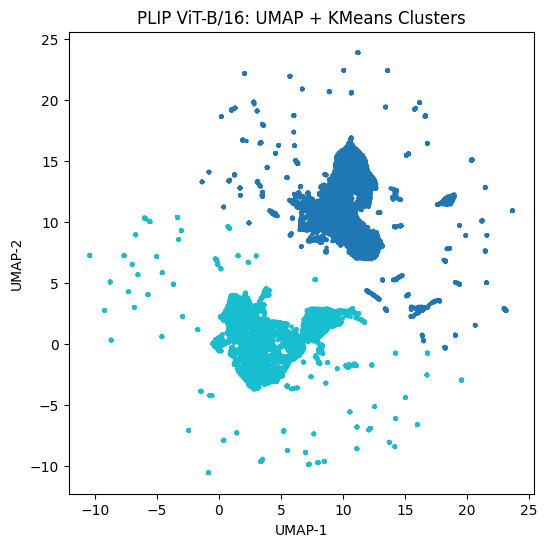

In [40]:
# Concatenate
embs1 = np.vstack(embs1)
embs2 = np.vstack(embs2)
embs3 = np.vstack(embs3)
labels = np.concatenate(labels)

# Cluster & Visualize
models = [
    ("OpenCLIP ViT-B/16", embs1),
    ("BiomedCLIP",      embs2),
    ("PLIP ViT-B/16",   embs3),
]

for name, embs in models:
    # UMAP to 2D
    reducer = umap.UMAP(n_components=2, random_state=42)
    embs_2d = reducer.fit_transform(embs)

    # K-Means into 2 clusters
    kmeans = KMeans(n_clusters=2, random_state=42).fit(embs_2d)
    clusters = kmeans.labels_

    # Plot colored by true labels
    plt.figure(figsize=(6, 6))
    plt.scatter(embs_2d[:,0], embs_2d[:,1], c=labels, cmap="coolwarm", s=5)
    plt.title(f"{name}: UMAP + True Labels")
    plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2")
    plt.show()

    # Plot colored by cluster assignments
    plt.figure(figsize=(6, 6))
    plt.scatter(embs_2d[:,0], embs_2d[:,1], c=clusters, cmap="tab10", s=5)
    plt.title(f"{name}: UMAP + KMeans Clusters")
    plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2")
    plt.show()

### Written Analysis (8 points)

Provide details on the open-ended experiments you conducted. In particular, provide justification for (1) the three (or more) models that you chose to evaluate, (2) the clustering algorithm and hyperparameters that you selected, and (3) the visualization algorithm you utilized. Then, summarize your key findings from your visualizations. Which models appear to generate the best image embeddings for this dataset? How can you tell?

[Your answer here]

**Written Analysis**

In the open-ended experiments, I compared the following three models:
- OpenCLIP ViT-B/16
- BiomedCLIP
- PLIP

The justifications are:
- OpenCLIP is the base model for comparison. As introduced in lecture, trained a massive amount of data, OpenCLIP serves a general-purpose foundation model. It would be interesting to see how such a generalist model would perform on domain specific dataset.
- BiomedCLIP, which was used in Part 2 and demonstrated improved zero-shot classification capabilities, is a fine-tuned version of CLIP model using biomedical specific dataset. We might see improved performance in the embedding space clustering as we posit this model has more knowledge about medical images.
- PLIP is a foundational model specificially trained for pathology WSI introduced in lecture. As PCAM is also a pathology WSI dataset, we might see that PLIP model can have the best performance as its ability in this specific field has been adequately trained.

**Clustering Algorithm and Hyperparameter Choice**

I used **UMAP** to conduct dimensionality reduction for the following reasons: (1) it is almost like an industry standard (2) UMAP preserves both the local neighborhoods and global structure better than linear methods such as PCA: distribution-wise, I assume that pathology images are embedded in a high dimensional non-linear manifold.

UMAP algorithm has some hyperparameter choices. The notable choices I have made are: (1) setting `n_component` to 2 to allow for 2D visualization later (2) setting a random seed for reproducibility when re-running. Other hyperparameters are left to default values.

I then used **K-Means** algorithm to cluster the data. This is a straightforward way to cluster the data based on calculated Euclidean distances. I set `n_cluster` to 2 as there are only 2 classes, and also set a random seed for reproducibility.

**Visualization Algorithm**

It is particularly nice to have visualization as we have used UMAP before to reduce the dimensionality of our image embeddings to 2D. I then provide the plot for both ground truth label and K-Means predicted labels.

**Discussion of Results**

In terms of the predicted cluster and ground truth label, all three models seem to generate not-so-good embeddings, suggesting either further techniques necessary when generating the embeddings, or further traininng required for these models. It might also be due to the fact that the clustering algorithm is relatively naive. However, if we look at the visualizations with the ground truth label, the models seem to be capturing something very interesting. Most non-metastatic images form a quite cohorent blub(s) in the UMAP plot, and we can see that images that deviate from the blub(s) in the reduced dimension space are almost always metastatic. PLIP model seems have the most pronounced differentiation, followed by BiomedCLIP, and then followed by OpenCLIP, which is expected as the training dataset differs.

## Submission Guidelines

When you have completed this assignment, please export to PDF by selecting File > Print > Save as PDF. **Please confirm that the outputs of all code cells are visible in the PDF.** Then, upload your PDF on Canvas.